https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os, sys

from custom_functions import *
from datetime import time
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', 100)

RANDOM_STATE = 100

raw_terry_path = os.path.join('..', 'data', 'raw', 'terry-stops.csv')
processed_data_path = os.path.join('..', 'data', 'processed')
UNKNOWN = 'Not provided'

In [130]:
# Calculate Officer Age
#if 'Officer YOB' in df.columns:
df['Reported Date'] = df['Reported Date'].astype('datetime64')
df['Officer YOB'] = df['Officer YOB'].astype('int')
df['Officer Age'] = df['Reported Date'].apply(lambda x: x.year) - df['Officer YOB']
#df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)

df.loc[df['Officer Age']>80, 'Officer Age'].value_counts().sum()

35

<AxesSubplot:>

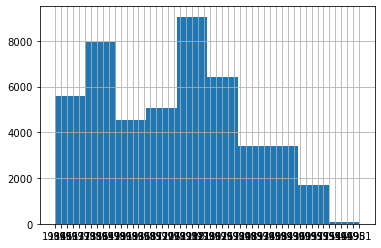

In [133]:
df['Officer YOB'].hist()

In [2]:
df = pd.read_csv(raw_terry_path, dtype='str')

# Strip spaces, as relevant
for col in df.columns:
    df[col] = df[col].str.strip()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47213 entries, 0 to 47212
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         47213 non-null  object
 1   Subject ID                47213 non-null  object
 2   GO / SC Num               47213 non-null  object
 3   Terry Stop ID             47213 non-null  object
 4   Stop Resolution           47213 non-null  object
 5   Weapon Type               47213 non-null  object
 6   Officer ID                47213 non-null  object
 7   Officer YOB               47213 non-null  object
 8   Officer Gender            47213 non-null  object
 9   Officer Race              47213 non-null  object
 10  Subject Perceived Race    47213 non-null  object
 11  Subject Perceived Gender  47213 non-null  object
 12  Reported Date             47213 non-null  object
 13  Reported Time             47213 non-null  object
 14  Initial Call Type     

In [22]:
# ------ CLEAN DATA ONE COLUMN AT A TIME -------
UNKNOWN = 'Not provided'


# Subject Age Group
df['Subject Age Group'].replace('-', UNKNOWN, inplace=True)

# Subject ID
df['Subject ID'].replace('-1', UNKNOWN, inplace=True)

# Weapon Type



# Officer Year of Birth
df['Officer YOB'] = df['Officer YOB'].astype('int')

# Officer Race
race_dict = {'Unknown': UNKNOWN, 
            'Not Specified': UNKNOWN,
            '-': UNKNOWN,
            'Other': UNKNOWN, 
            'Unknown': UNKNOWN}
df['Officer Race'].replace(race_dict, inplace=True)
df['Subject Perceived Race'].replace(race_dict, inplace=True)


# Subject Perceived Gender
gender_dict = {'Unable to Determine': UNKNOWN,
              '-': UNKNOWN,
              'Gender Diverse (gender non-conforming and/or transgender)': 'Non-Binary',
               'N': 'Non-Binary',
               'M': 'Male',
               'F': 'Female'}
df['Subject Perceived Gender'].replace(gender_dict, inplace=True)
df['Officer Gender'].replace(gender_dict, inplace=True)


# Weapon Type
weapon_type_dict = {'Firearm Other': 'Firearm', 
                    'Lethal Cutting Instrument': 'Knife', 
                    'Handgun': 'Firearm', 
                    '-': 'None', 
                    'Club, Blackjack, Brass Knuckles': 'Club/Melee', 
                    'Knife/Cutting/Stabbing Instrument': 'Knife', 
                    'Other Firearm': 'Firearm', 
                    'Rifle': 'Firearm', 
                    'Fire/Incendiary Device': 'Other', 
                    'Blunt Object/Striking Implement': 'Club/Melee', 
                    'Firearm (unk type)': 'Firearm', 
                    'Mace/Pepper Spray': 'Other', 
                    'None/Not Applicable': 'None', 
                    'Club': 'Club/Melee', 
                    'Taser/Stun Gun': 'Other', 
                    'Shotgun': 'Other', 
                    'Brass Knuckles': 'Club/Melee', 
                    'Automatic Handgun': 'Firearm', 
                    'Blackjack': 'Club/Melee', 
                    'Personal Weapons (hands, feet, etc.)': 'Club/Melee'}
df['Weapon Type'].replace(weapon_type_dict, inplace=True)


# Reported date and hour
df['Reported Date'] = df['Reported Date'].astype('datetime64')
df['Reported Hour'] = [int(x[:2]) for x in df['Reported Time']]
    
    
# Call Type
call_type_dict = {'-': UNKNOWN,
                 'SCHEDULED EVENT (RECURRING)': UNKNOWN,
                 'TEXT MESSAGE': UNKNOWN}
df['Call Type'].replace(call_type_dict, inplace=True)
    
    
# Frisk Flag
df['Frisk Flag'].replace('-', np.nan, inplace=True)

# Precinct
precinct_dict = {'-': UNKNOWN,
                'FK ERROR': UNKNOWN,
                'SouthWest': 'Southwest'}
df['Precinct'].replace(precinct_dict, inplace=True)


# Sector
df['Sector'].replace(['99', '-'], UNKNOWN, inplace=True)


# Beat
df['Beat'].replace(['S', '99', '-'], UNKNOWN, inplace=True)


# Categorize "Call Types". Variable used to create dictionary in CSV
# call_types = pd.concat([df['Call Type'], df['Initial Call Type'], df['Final Call Type']]).value_counts().keys().values
# path = os.path.join('..', 'data', 'categorize call types.csv')
# call_type_dictionary = pd.read_csv(path)
# call_type_dictionary = dict(zip(call_type_dictionary.iloc[:, 0], call_type_dictionary.iloc[:, 1]))


    
#--- INCOMPLETE!
# df['Initial Call Type'] = df['Initial Call Type'].map(call_type_dictionary)
# df['Final Call Type'] = df['Final Call Type'].map(call_type_dictionary)


# Age group manipulation

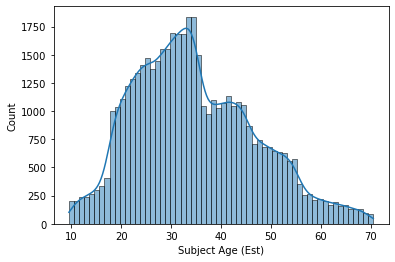

In [52]:
# ------ ESTIMATE SUBJECT AGE ------

np.random.seed(RANDOM_STATE)

df['Subject Age Group'].replace('-', UNKNOWN, inplace=True)

years_in_category = {'1 - 17': [10, 17],
'18 - 25': [18, 25],
'26 - 35': [26, 35],
'36 - 45': [36, 45],
'46 - 55': [46, 55],
'56 and Above': [56, 70]}

def predict_ages():
    avg, std = calculate_mean_and_std()
    
    ages = []
    for age_categorical in df['Subject Age Group']:
        age = predict_age_from_category(age_categorical, avg, std)
        ages.append(age)
    return ages


def calculate_mean_and_std():
    xy = {}
    
    age_group_counts = dict(df['Subject Age Group'].value_counts())
    
    for age_group in df['Subject Age Group'].replace(UNKNOWN, np.nan).dropna().unique():
        age_range_list = set_range(age_group)
        age_range_ct = age_group_counts[age_group]
        
        for item in age_range_list:
            xy[item] = int(age_range_ct/len(age_range_list))
    
    x = np.array(list(xy.keys()))
    y = np.array(list(xy.values()))
    avg = x.mean()
    std = x.std()
    return avg, std



def set_range(age_range):
    age_range = years_in_category[age_range]
    start = age_range[0]
    stop = age_range[1]
    return np.linspace(start, stop, stop-start+1)



def predict_age_from_category(bucket, avg, std):

    if bucket == UNKNOWN:
        year_range = np.array(list(years_in_category.values())).flatten()
        min_age = year_range.min()
        max_age = year_range.max()
    else:
        year_range = years_in_category[bucket]
        min_age = year_range[0]
        max_age = year_range[1]
    age = 0
    while ((age <= min_age-0.5) or (age > max_age+0.5)):
        age = np.random.normal(avg, std)
    return age


df['Subject Age (Est)'] = predict_ages()
sns.histplot(df['Subject Age (Est)'], bins=60, kde=True);
plt.savefig('hist.png')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47213 entries, 0 to 47212
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         47213 non-null  object 
 1   Subject ID                47213 non-null  object 
 2   GO / SC Num               47213 non-null  object 
 3   Terry Stop ID             47213 non-null  object 
 4   Stop Resolution           47213 non-null  object 
 5   Weapon Type               47213 non-null  object 
 6   Officer ID                47213 non-null  object 
 7   Officer YOB               47213 non-null  object 
 8   Officer Gender            47213 non-null  object 
 9   Officer Race              47213 non-null  object 
 10  Subject Perceived Race    47213 non-null  object 
 11  Subject Perceived Gender  47213 non-null  object 
 12  Reported Date             47213 non-null  object 
 13  Reported Time             47213 non-null  object 
 14  Initia

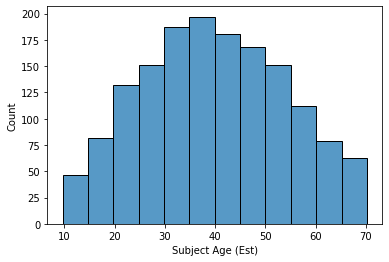

In [48]:
interpolated_rows = df.loc[df['Subject Age Group'] == UNKNOWN]
sns.histplot(interpolated_rows['Subject Age (Est)'], bins=12)
plt.savefig('hist.png')

In [6]:
# Engineer new features

# Calculate Officer Age
if 'Officer YOB' in df.columns:
    df['Officer Age'] = df['Reported Date'].apply(lambda x: x.year) - df['Officer YOB']
    df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)
    df.drop('Officer YOB', axis=1, inplace=True)

    
# Determine whether or not weapon was involved
#has_weapon = lambda x: 'No' if x == 'None' else 'Yes'
df['Weapon (Y/N)'] = (df['Weapon Type'] != 'None').astype('int')


# Calculate the number of stops per subject
if 'Subject ID' in df.columns:
    offense_ct_dict = dict(df['Subject ID'].value_counts())
    df['Offense Count'] = df['Subject ID'].map(offense_ct_dict)
    # Identify whether a subject has been involved in multiple stops
    df['Repeat Offender (Y/N)'] = (df['Offense Count'] > 1).astype('int')
    # Drop "Offense Count" for now given the number of missing values
    if 'Offense Count' in df:
        df.drop('Offense Count', axis=1, inplace=True)
    df.drop('Subject ID', axis=1, inplace=True)




# Identify whether race of officer is same as race of subject
df['Same Race (Y/N)'] = (df['Officer Race'] == df['Subject Perceived Race']).astype('int')

# Identify whether gender of officer is same as gender of subject
df['Same Gender (Y/N)'] = (df['Officer Gender'] == df['Subject Perceived Gender']).astype('int')

In [7]:
# Rename columns and drop 'na' rows
if 'Arrest Flag' in df.columns:
    df['Arrest (Y/N)'] = (df['Arrest Flag'] == 'Y').astype('int')
    df.drop('Arrest Flag', axis=1, inplace=True)
    
if 'Frisk Flag' in df.columns:
    df['Frisk (Y/N)'] = (df['Frisk Flag'] == 'Y').astype('int')
    df.drop('Frisk Flag', axis=1, inplace=True)

# Remove missing values and reset index
#df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.dropna(inplace=True)
df['Officer Age'] = df['Officer Age'].astype('int')

# Graphical EDA

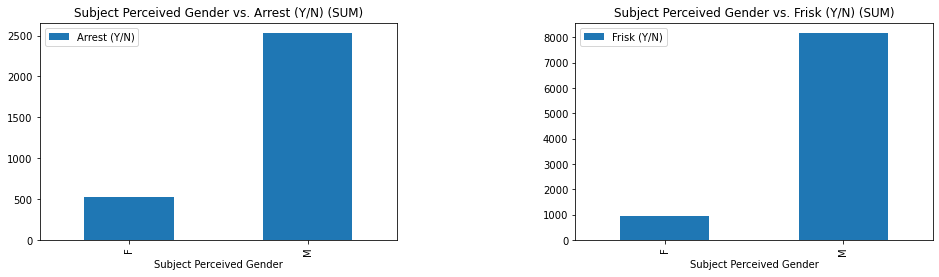

  Subject Perceived Gender  Arrest (Y/N)  Frisk (Y/N)
1                        M          2530         8173
0                        F           533          951
--------------------------------------------------------------------




In [8]:
# BAR GRAPHS FOR ***AVERAGE OR SUM*** OF METRICS

df_graphical = pd.concat([df, pd.get_dummies(df['Stop Resolution'], prefix='Resolution')], axis=1)

# Average metrics by age group
x_axis = 'Subject Age Group'
y_axis = ['Arrest (Y/N)', 'Frisk (Y/N)']#, 'Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
#bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=False)

# Average metrics by subject race
x_axis = 'Subject Perceived Race'
#y_axis = ['Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
#bar_plot(df_graphical, x_axis, y_axis, 'sum', verbose=True)

# Gender metrics
x_axis = 'Subject Perceived Gender'
y_axis = ['Arrest (Y/N)', 'Frisk (Y/N)']
bar_plot(df_graphical, x_axis, y_axis, 'sum', verbose=True)

# Officer race
x_axis = 'Officer Race'
#bar_plot(df_graphical, x_axis, y_axis, 'mean',verbose=True)

# Officer gender
x_axis = 'Officer Gender'
#bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Officer gender
x_axis = 'Officer Age'
#bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40672 entries, 0 to 47212
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Subject Age Group         40672 non-null  object        
 1   GO / SC Num               40672 non-null  object        
 2   Terry Stop ID             40672 non-null  object        
 3   Stop Resolution           40672 non-null  object        
 4   Weapon Type               40672 non-null  object        
 5   Officer ID                40672 non-null  object        
 6   Officer Gender            40672 non-null  object        
 7   Officer Race              40672 non-null  object        
 8   Subject Perceived Race    40672 non-null  object        
 9   Subject Perceived Gender  40672 non-null  object        
 10  Reported Date             40672 non-null  datetime64[ns]
 11  Reported Time             40672 non-null  object        
 12  Initial Call Type 

# Refine dataset

In [20]:
# Refine dataset to continuous and OHE values

# Separate columns by type
obj_columns = df.select_dtypes('object').columns
continuous_columns = df.drop(obj_columns, axis=1).columns

# Determine which columns are most valuable to OHE
cols_to_ohe = []
for col in obj_columns:
    if len(df[col].value_counts().index) < 30:
        cols_to_ohe.append(col)

df_refined = pd.concat([df[continuous_columns], df[cols_to_ohe]], axis=1)
df_refined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40672 entries, 0 to 47212
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Reported Date             40672 non-null  datetime64[ns]
 1   Reported Hour             40672 non-null  int64         
 2   Officer Age               40672 non-null  int32         
 3   Weapon (Y/N)              40672 non-null  int32         
 4   Repeat Offender (Y/N)     40672 non-null  int32         
 5   Same Race (Y/N)           40672 non-null  int32         
 6   Same Gender (Y/N)         40672 non-null  int32         
 7   Arrest (Y/N)              40672 non-null  int32         
 8   Frisk (Y/N)               40672 non-null  int32         
 9   Subject Age Group         40672 non-null  object        
 10  Stop Resolution           40672 non-null  object        
 11  Weapon Type               40672 non-null  object        
 12  Officer Gender    

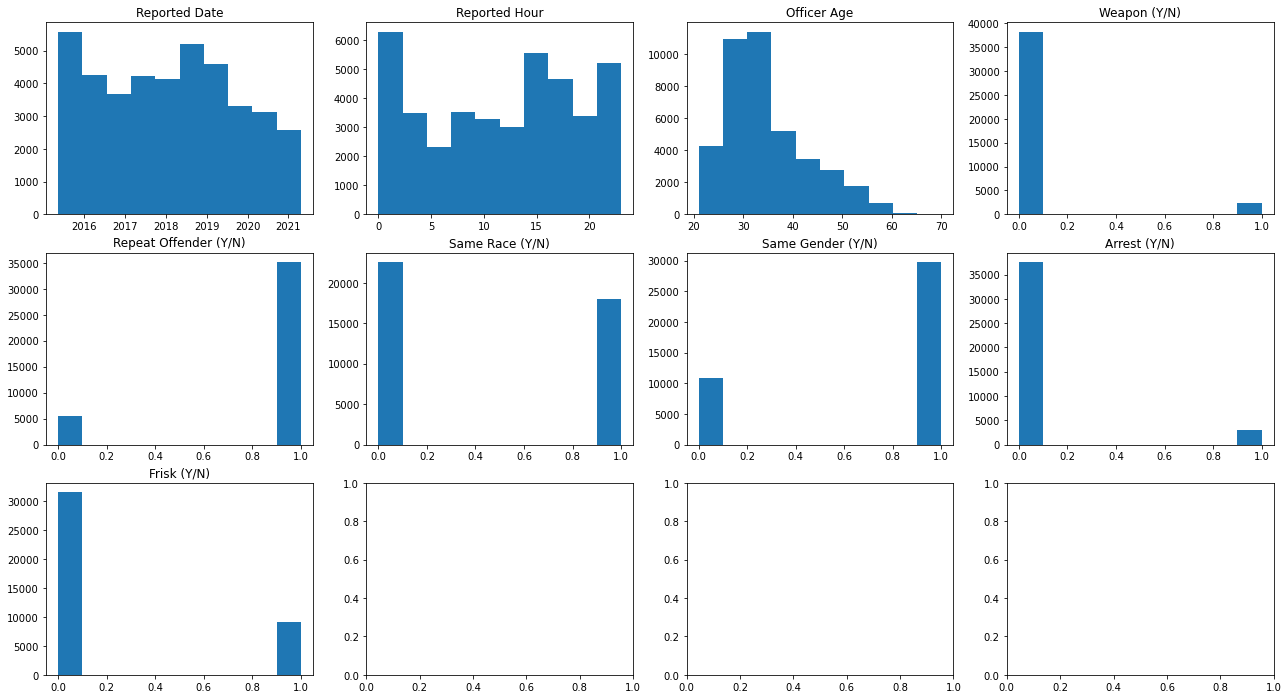

In [21]:
nrows = int(np.ceil(len(continuous_columns)/4))
fig, axes = plt.subplots(ncols=4, nrows=nrows, figsize=(22, 4*nrows))

for ax, col in zip(axes.flatten(), continuous_columns):
    ax.hist(df_refined[col])
    ax.set_title(col)

# Begin encoding and modeling

In [26]:
# Split data
y_label = 'Arrest (Y/N)'
X = df_refined.drop([y_label, 'Stop Resolution', 'Frisk (Y/N)', 
                     'Call Type', 'Reported Date', 'Reported Hour'], axis=1)
y = df_refined[y_label]

X, X_test, y, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# Remove temptation to touch test dataset
test_data = {'X_test': X_test, 'y_test': y_test}
with open (os.path.join(processed_data_path, 'test_data.pickle'), 'wb') as f:
    pickle.dump (test_data, f)
X_test = None
y_test = None

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30504 entries, 17310 to 44654
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Officer Age               30504 non-null  int32 
 1   Weapon (Y/N)              30504 non-null  int32 
 2   Repeat Offender (Y/N)     30504 non-null  int32 
 3   Same Race (Y/N)           30504 non-null  int32 
 4   Same Gender (Y/N)         30504 non-null  int32 
 5   Subject Age Group         30504 non-null  object
 6   Weapon Type               30504 non-null  object
 7   Officer Gender            30504 non-null  object
 8   Officer Race              30504 non-null  object
 9   Subject Perceived Race    30504 non-null  object
 10  Subject Perceived Gender  30504 non-null  object
 11  Precinct                  30504 non-null  object
 12  Sector                    30504 non-null  object
dtypes: int32(5), object(8)
memory usage: 2.7+ MB


In [14]:
ohe = OneHotEncoder(drop='first')
ss = StandardScaler()

string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_exclude=['object', 'datetime'])

preprocessor = make_column_transformer((ohe, string_selector), (ss, number_selector))
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000024EEAB0B160>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000024EEAB0B0D0>)])

In [17]:
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
pipeline = make_pipeline(preprocessor, model)
pipeline.fit(X, y)
print('Train:', pipeline.score(X, y))


# model = KNeighborsClassifier(leaf_size=5, n_neighbors=5)
# pipeline = make_pipeline(preprocessor, model)
# pipeline.fit(X, y)
# print('Train:', pipeline.score(X, y))

Train: 0.923682140047207
Test: 0.9238788355625491


# To do

- Decide if there's anything we can do with reported time to get to stop time (see pseudo code below)
    - Consider "time of year / season"
- Should I switch to F1 instead of accuracy?
- Is the class imbalance sufficient enough to warrant resampling? (see histograms above)
    - Look into confusion matrices
- Once a model is selected, how should the results be presented?
    - Can also look into what the error is for each side of the decision
    - Back up any sort of conclusion with hypothesis testing
    - If it is a tree-based model, consider printing out the graphical representation of the tree that was used
    - Regarding how to gain meaning from results:
        - Perhaps use hypothesis testing to see extent of results
        - If linear model: bootstrapping can be used to get coefficients - discuss in 1-on-1 next week. 
        - If non-linear (non-parametric) models: once final model is selected, run it again without race (e.g.) to see how error changes. Also see how much the error changes when dropping other features?
    - Could also use step-forward (e.g.) feature selection function that was implemented in the lab project. Make sure to change from R2 eval metric to F1 (or whatever I end up using). Also make sure this is looking at the result on validation data, not just overall data (reduce overfitting). 
- Plan going forward:
    - Complete feature engineering in progress above
    - Implement cross-val score and avoid using testing data at all until final model is selected
    - Implement ModelHistory class 
    - Try random forest and KNN models, including grid search
    - Compare results, decide on best model